In [216]:
%matplotlib inline
import numpy as np
import pandas as pd
import sqlite3
from scipy import stats, optimize, interpolate, integrate
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save
import subprocess
bar = lambda k,x: np.sqrt(k**2 - x**2)

In [5]:
with sqlite3.connect(r'd:\data\scriptie\wrds.sqlite') as con:
    bla = pd.read_sql(
        """select strike_price/close strike, (best_bid+best_offer)/2/close option, rate rf, maturity/365. t
        from spx where date(observation) between date('2001-03-29') and date('2001-03-29')
        and maturity between 75 and 105--= (select min(maturity) from spx where date(observation) = date('2000-09-18'))
        order by strike""",
        con)

In [315]:
N = int(1e5)
W = np.random.normal(size=(2, N))
# Sh= 1
r = .5
qS = -0.008
qV = -0.04
# sV = .25
sS = .22
Sh = 1.5*qS/sS

gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_lb = np.array([qS/sS, gamma_lb])

gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_ub = np.array([qS/sS, gamma_ub])

sigmaM = np.array([qS/sS, 0])

def get_fit(row, sigmaM, qS=qS):
    ks, cs, t, rf, sS = row.loc[['strike', 'option', 't', 'rf', 'imp_vol']].values
    st = np.sqrt(t)
    muM = -.5 * sigmaM @ sigmaM.T*t
    M = np.exp(muM + st*sigmaM @ W)
    
    sigmaV = np.array([r, bar(1,r)])*st
    
    def fit(sV):
        muV = -qV*t -.5*sV**2*t
        V = np.exp(muV + sV*sigmaV @ W)
        
        return (np.mean(M*np.maximum(0,V-ks)) - cs)**2
    return fit

def C(row):
    ks, cs, t, r = row.loc[['strike', 'option', 't', 'rf']].values
    def blep(sigma):
        d1 = ( sigma/2 + r/sigma )*np.sqrt(t) - np.log(ks)/np.sqrt(t)/sigma
        return ( stats.norm.cdf(d1) - ks*np.exp(-r*t)*stats.norm.cdf(d1-sigma*np.sqrt(t)) - cs )**2
    return blep

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


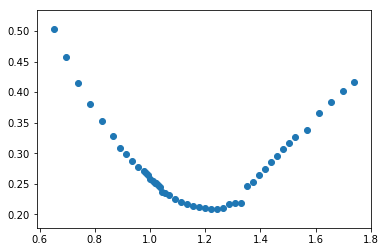

In [13]:
bla['imp_vol'] = bla.apply(lambda row: optimize.minimize_scalar(C(row), method='bounded', bounds=[0,1], tol=1e-12).x, axis=1)
# optimize.minimize_scalar(C(bla.iloc[1,:]), method='golden', tol=1e-12)
plt.scatter(bla.strike, bla.imp_vol)
# bla

In [316]:
bla['lb_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM_lb), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)
bla['m_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)
bla['ub_vol'] = bla.apply(lambda row: optimize.minimize_scalar(get_fit(row, sigmaM_ub), method='bounded', bounds=[0,1], options={'xatol':1e-5}).x, axis=1)

In [317]:
bla.loc[0, 'm_vol'] = bla.loc[0, 'imp_vol'] + .01

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{groupplots}
[master c0ee240] img
 1 file changed, 9 insertions(+), 2 deletions(-)
Auto-merging img/volsmile.tex
Merge made by the 'recursive' strategy.
 img/volsmile.tex      | 2 +-
 sections/empirics.tex | 2 +-
 2 files changed, 2 insertions(+), 2 deletions(-)



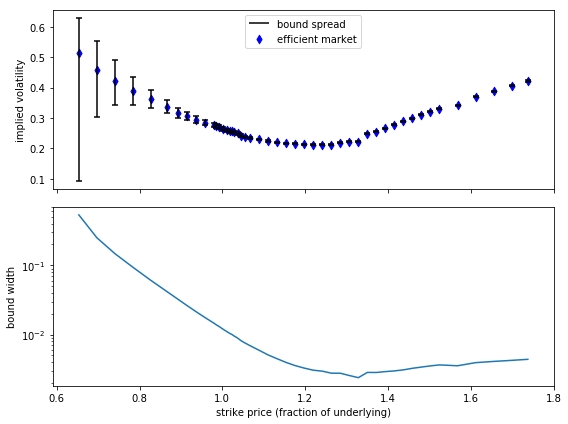

In [348]:
fig, (ax, axt) = plt.subplots(figsize=(8,6), nrows=2, sharex=True)

axt.plot(bla.strike, bla.lb_vol - bla.ub_vol, label='bound spread (log)')
axt.set_yscale('log')
axt.set_ylabel('bound width')

ax.vlines(bla.strike, bla.lb_vol, bla.ub_vol, colors='k', label='bound spread')
ax.scatter(bla.strike, bla.m_vol, marker='d', c='b', label='efficient market')
# ax.plot(bla.strike, bla.imp_vol, 'k', label='Black-Scholes')
# ax.set_yscale('log')
ax.legend(loc=9)
ax.scatter(bla.strike, bla.lb_vol, marker='_', c='k', label='lower bound')
ax.scatter(bla.strike, bla.ub_vol, marker='_', c='k', label='upper bound')
ax.set_ylabel('implied volatility')
axt.set_xlabel('strike price (fraction of underlying)')
fig.tight_layout()

tikz_save('../scriptie/img/volsmile.tex', figureheight='1.5in', figurewidth='4in')
print(subprocess.check_output(r'cd ..\scriptie\ && git commit -a -m "img" && git pull && git push', shell=True).decode('utf-8'))

In [391]:
7./3 - 4./3 -1

2.220446049250313e-16

In [511]:
r = .5
qS = -0.008
qV = -0.01
sV = .25
sS = .25
rf = .0

smpl = 10000
steps = 5

db = sqlite3.connect(r'd:\discretization.sqlite')
db.execute('create table if not exists result(steps int, time_passed float, surplus float)')

def C(s, t):
    """Black-Scholes value of the option at time t, given current asset value s"""
    d1 = ( sS/2 + rf/sS )*np.sqrt(1-t) + np.log(s)/np.sqrt(1-t)/sS
    return s*stats.norm.cdf(d1) - np.exp(-rf*(1-t))*stats.norm.cdf(d1-sS*np.sqrt(1-t))

def delta(s, t):
    """Required investment in s for a Black-Scholes delta hedge at time t given current value s"""
    d1 = ( sS/2 + r/sS )*np.sqrt(1-t) + np.log(s)/np.sqrt(1-t)/sS
    return -stats.norm.cdf(d1)

from time import time
tm = time()

for steps in range(5, 100):
    t = np.arange(0, 1+3e-16, 1/steps)
    S = np.exp((rf-qV)*t -.5*sV**2*t + sV*np.cumsum(np.concatenate((np.zeros((smpl,1)), np.random.normal(size=(smpl, steps))),1)/np.sqrt(steps), axis=1))

    # plt.plot(S.T)
    avg = 0
    for s in S:
        value = 1*np.exp(-rf)-C(s[0], t[0]) # starting capital: the strike minus the option
        for i in range(1, len(t)-1):
            value += s[i]*(-delta(s[i], t[i]) + delta(s[i-1], t[i-1])) # change in capital: the change in delta hedge times current value
        value += max(s[-1]-1, 0) + s[-1]*delta(s[i], t[i]) # final capital: executed option and current hedge value
        avg += value
    avg /= len(S)

    dt = time() - tm
    print(steps, dt, avg)
    tm = time()
    db.execute('insert into result(steps, time_passed, surplus) values(?,?,?)', [steps, dt, avg])


8.897657871246338


0.0126309524257178

In [513]:
50*100*9/3600

12.5

6.33305172195e-05
1.00821197881 1.0000597736 0.827562176053


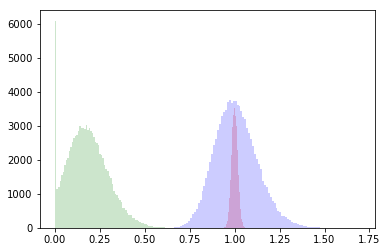

In [272]:
N = int(1e5)
W = np.random.normal(size=(2, N))
# Sh= 1
r = .5
qS = -0.008
qV = -0.04
sV = .25
sS = .22
Sh = 1.5*qS/sS

gamma_lb = - np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_lb = np.array([qS/sS, gamma_lb])

gamma_ub = + np.sqrt(Sh**2 - (qS/sS)**2)
sigmaM_ub = np.array([qS/sS, gamma_ub])

sigmaM = np.array([qS/sS, 0])

ks, cs, t, rf = bla.loc[4, ['strike', 'option', 't', 'rf']].values
st = np.sqrt(t)

muM = -.5 * sigmaM @ sigmaM.T*t
M = np.exp(muM + st*sigmaM @ W)

sigmaV = np.array([r, bar(1,r)])*sV*st
muV = -qV*t -.5*sV**2*t
V = np.exp(muV + sigmaV @ W)

print((np.mean(np.maximum(0, M*V-ks)) - cs)**2)

plt.hist(M, bins=100, alpha=.2, color='r')
plt.hist(V, bins=100, alpha=.2, color='b')
plt.hist(M*np.maximum(0, V-ks), bins=100, alpha=.2, color='g');
print(np.mean(V), np.mean(M), ks)

In [117]:
def _d_es(a):
    return lambda x: -x/a*np.exp(-x**2/2)/np.sqrt(2*np.pi)
es = lambda a: integrate.quad(_d_es(a), -float('inf'), stats.norm.ppf(a))[0]

In [541]:
with sqlite3.connect(r'd:\data\scriptie\wrds.sqlite') as con:
    df = pd.read_sql('select observation, close from spx_options group by observation, close', con, index_col='observation')

In [548]:
df = df.shift(1).div(df).squeeze()

In [555]:
df.std()

0.012580621356582356

In [277]:
options = pd.read_csv('options.csv').drop(['secid', 'index_flag', 'issue_type'], axis=1)
zerocd = pd.read_csv('zero_coupon_dividend.csv')
options.date = pd.to_datetime(options.date, format='%Y%m%d')
zerocd.date = pd.to_datetime(zerocd.date, format='%Y%m%d')
options['premiumfrac'] = options.premium / options.forward_price
options['T'] = options.days/364

In [278]:
options.zerocd = np.log(options.zerocd.div(100).add(1))
calls = options.loc[options.cp_flag == 'C', :]
puts = options.loc[options.cp_flag == 'P', :]

AttributeError: 'DataFrame' object has no attribute 'zerocd'

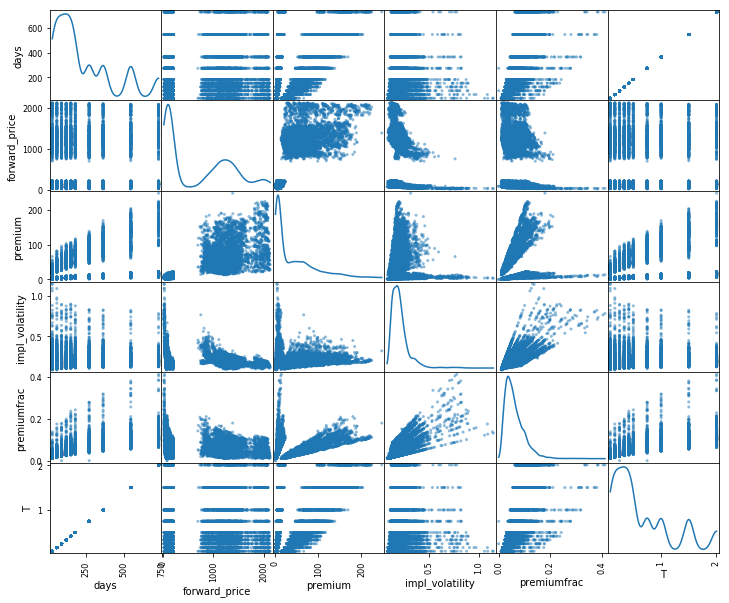

In [284]:
from pandas.plotting import scatter_matrix

# options.merge(sec, on=['date', 'ticker'])
# sec.loc[sec.volume > 0, :]
options.loc[options.date=='2006-05-19']
# sec.loc[sec.date == '2006-05-19']
# _x = np.arange(-3,3,.01)
# plt.plot(_x, stats.norm.cdf(_x) - stats.norm.cdf(-_x), 'b')
# plt.plot(_x, 2*stats.norm.cdf(_x)-1, 'k')
# plt.scatter(options.premiumfrac, options.impl_volatility)
scatter_matrix(options.sample(n=10000), diagonal='kde', figsize=(12,10));